## Q-learning (3 points)

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
# In google collab, uncomment this:
# !wget https://bit.ly/2FMJP5K -q -O setup.py
# !bash setup.py 2>&1 1>stdout.log | tee stderr.log

# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [250]:
# %%writefile qlearning.py
from collections import defaultdict
import random
import math
import numpy as np

totals = {}

class QLearningAgent:
    def __init__(self, learning_rate_alpha, exploration_prob_epsilon, discount_gamma, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.exploration_prob (aka epsilon for epsilon-greedy)
          - self.learning_rate (aka alpha)
          - self.discount (aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0.))
        self.learning_rate = learning_rate_alpha
        self.exploration_prob = exploration_prob_epsilon
        self.discount = discount_gamma

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            # terminate state, it's value = 0.
            return 0.
        
        action_values = self._qvalues[state]
        value = max(action_values[action] for action in possible_actions)
        return value

    @timed(totals, 'u')
    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        r, gamma, alpha = reward, self.discount, self.learning_rate
        Qsa = self._qvalues[state][action]
        Vns = self.get_value(next_state)

        new_qvalue = (1 - alpha) * Qsa + alpha * (r + gamma * Vns)
        self.set_qvalue(state, action, new_qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            # terminate state, no actions
            return None

        best_action, best_value = None, None
        action_values = self._qvalues[state]
        for action in possible_actions:
            value = action_values[action]
            if best_action is None or value > best_value:
                best_action, best_value = action, value
        
        return best_action

    @timed(totals, 'a')
    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.exploration_prob, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            return None

        # agent parameters:
        epsilon = self.exploration_prob
        action = None
        
        if np.random.uniform(low=0., high=1.) <= epsilon:
            action = np.random.choice(possible_actions)
        else:
            action = self.get_best_action(state)

        return action

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [251]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n
possible_actions = list(range(n_actions))

In [252]:
from functools import wraps
from timeit import default_timer as timer
    
def timed(totals, timer_name='#'):
    def dec_wrapper(f):
        @wraps(f)
        def wrapper(*args, **kwargs):
            start = timer()
            result = f(*args, **kwargs)
            elapsed = timer() - start

            totals[timer_name] = totals.get(timer_name, 0) + elapsed
            return result
        return wrapper
    return dec_wrapper

In [253]:
@timed(totals, 'T')
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

eps = 1.0684883734137816e-05 mean reward = 8.54


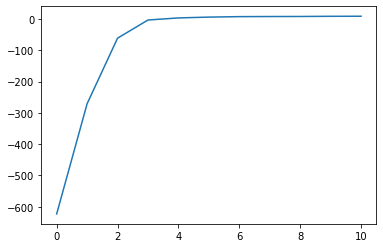

In [254]:
# from qlearning import QLearningAgent
from IPython.display import clear_output

agent = QLearningAgent(
    learning_rate_alpha=0.5, exploration_prob_epsilon=0.25, discount_gamma=0.99,
    get_legal_actions=lambda s: possible_actions
)

totals.clear()
rewards, cur_rewards = [], []
for i in range(1001):
    cur_rewards.append(play_and_train(env, agent))
    agent.exploration_prob *= 0.99

    if i % 100 == 0:
        clear_output(True)
        avg_reward, cur_rewards = np.mean(cur_rewards), []
        rewards.append(avg_reward)
        print('eps =', agent.exploration_prob, 'mean reward =', avg_reward)
        plt.plot(rewards)
        plt.show()

In [255]:
totals

{'a': 0.15559247651253827, 'u': 0.12915170929045416, 'T': 0.7743340880260803}

# Binarized state spaces

Use agent to train efficiently on CartPole-v0.
This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state:[-0.04200069 -0.03228652 -0.03696177  0.00513719]


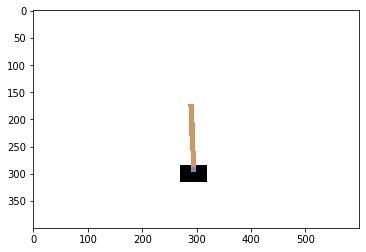

In [180]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
possible_actions = list(range(n_actions))

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

env.close()

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

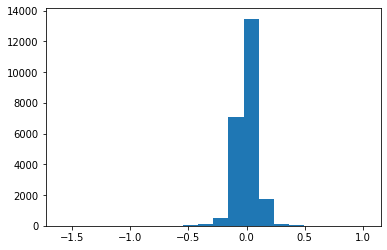

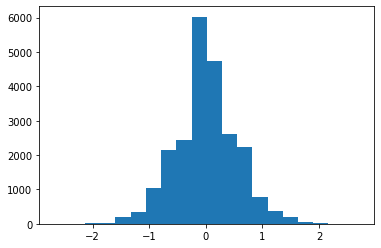

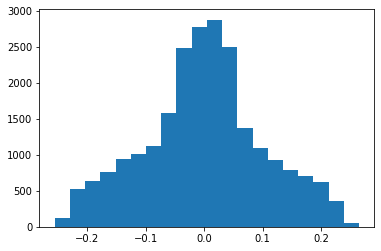

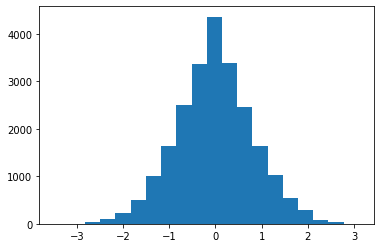

In [59]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Binarize environment

(26,)


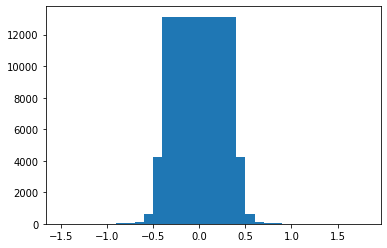

(45,)


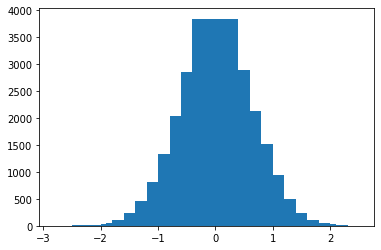

(7,)


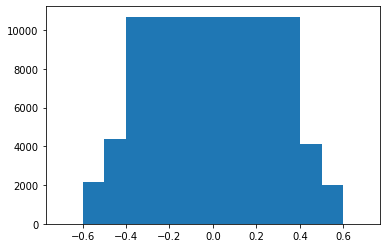

(61,)


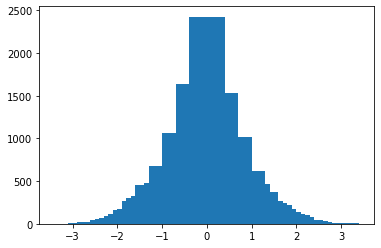

In [256]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):

    def observation(self, state):
        state = (
            round(state[0], 1),
            round(state[1], 1),
            round(state[2], 1),
            round(state[3], 1)
        )

        return tuple(state)

env = Binarizer(gym.make("CartPole-v0"))

all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)
for obs_i in range(env.observation_space.shape[0]):
    xs, ys = np.unique(all_states[:, obs_i], return_counts=True)
    print(xs.shape)
    plt.bar(xs, ys)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.
* A reasonable agent should get to an average reward of >=50.

eps = 0.02049816939617154 mean reward = 84.73


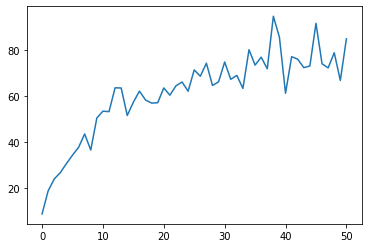

In [214]:
agent = QLearningAgent(
    learning_rate_alpha=0.5, exploration_prob_epsilon=0.25, discount_gamma=0.99,
    get_legal_actions=lambda s: possible_actions
)

rewards, cur_rewards = [], []
for i in range(5001):
    cur_rewards.append(play_and_train(env, agent))
    agent.exploration_prob *= 0.9995
    
    if i % 100 == 0:
        clear_output(True)
        avg_reward, cur_rewards = np.mean(cur_rewards), []
        rewards.append(avg_reward)
        print('eps =', agent.exploration_prob, 'mean reward =', avg_reward)
        plt.plot(rewards)
        plt.show()